In [255]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import xgboost as xgb

In [256]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.style.use('seaborn-whitegrid')
mpl.rc('font', size=13)
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['axes.linewidth'] = 2

C:\Users\Danil\AppData\Local\Temp\ipykernel_1416\2502515862.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [257]:
in_df = pd.read_csv(r"..\Filtering_data\filtered_df.csv")
sity_df = in_df[in_df.columns[5]]
sity_df[365:]

365     -5.25
366     -2.94
367     -6.84
368    -20.74
369    -20.54
        ...  
7295   -15.00
7296    -7.99
7297    -3.28
7298    -7.28
7299    -4.07
Name: Степной, Length: 6935, dtype: float64

In [258]:
def form_train_data (in_df: pd.Series, day_in_row:int, forecast_days:int) -> (np.array, np.array):
    df = pd.DataFrame()
    df = pd.concat([in_df.shift(i) for i in range(day_in_row,0,-1)], axis=1)
    df = df[day_in_row:]
    df.columns = range(day_in_row)

    index_df = range(df.index[0], df.index[-1] + 1 - forecast_days)
    df_y = pd.DataFrame(index = list(index_df), columns=[0])
    for i in index_df:
        df_y[0][i] = in_df[i+forecast_days]

    df = df[:-1*forecast_days]

    return (df, df_y)

form_train_data(sity_df, 365, 1)[1]

,0
365,-2.94
366,-6.84
367,-20.74
368,-20.54
369,-21.84
...,...
7294,-15.0
7295,-7.99
7296,-3.28
7297,-7.28


In [259]:
x, y = form_train_data(sity_df, 365, 365)
train_size = 0.7
train_stop = int(x.index[-1]*train_size)

valid_size = 0.1
valid_stop = train_stop + int(x.index[-1]*valid_size)

test_size = 0.1
test_stop = valid_stop + int(x.index[-1]*test_size)

x_train = x[ : train_stop].values
y_train = y[ : train_stop].values

x_valid = x[train_stop : valid_stop].values
y_valid = y[train_stop : valid_stop].values

x_test = x[valid_stop : test_stop].values
y_test = y[valid_stop : test_stop].values

x_valid

array([[ -8.84,  -5.65,  -3.25, ..., -18.23, -11.23,  -6.54],
       [ -5.65,  -3.25,  -0.95, ..., -11.23,  -6.54, -10.54],
       [ -3.25,  -0.95,  -4.86, ...,  -6.54, -10.54,  -7.35],
       ...,
       [ -5.72, -19.93, -12.93, ...,  -4.51,  -4.61,  -7.02],
       [-19.93, -12.93,  -8.24, ...,  -4.61,  -7.02,  -7.42],
       [-12.93,  -8.24, -12.24, ...,  -7.02,  -7.42, -21.63]])

<Axes: >

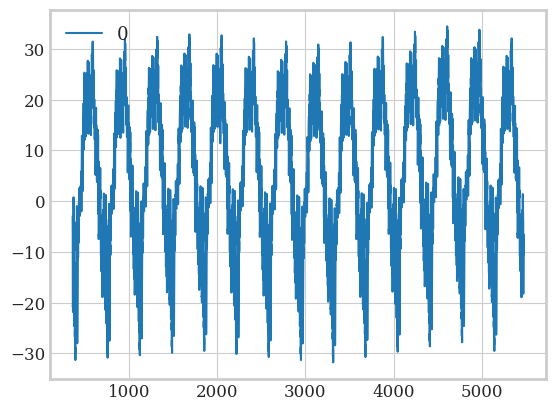

In [260]:
y[ : train_stop].plot()

In [261]:
params = {
    "objective": "reg:squarederror",
    "n_estimators":200,
    "max_depth": 28,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "colsample_bylevel": 0.8,
    "reg_lambda": 0.1,
    "eval_metric": "mae",
    "random_state": 42,
}

reg = xgb.XGBRegressor(**params)
reg.fit(x_train,
        y_train,
        verbose=False,
        eval_set= [(x_train, y_train), (x_valid, y_valid)],
        early_stopping_rounds= 3
        )

d:\Anaconda\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=28, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

1.0810804385053114


Text(0, 0.5, 'MAE Deviance')

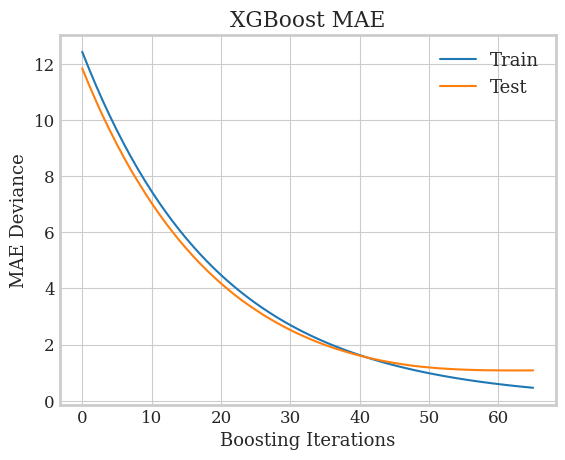

In [262]:
results = reg.evals_result()
print(results['validation_1']['mae'][-1])
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')

plt.legend()
plt.title('XGBoost MAE')
plt.xlabel("Boosting Iterations")
plt.ylabel("MAE Deviance")

In [263]:
results['validation_1']['mae'][-1]

1.0810804385053114

1.847902938634239


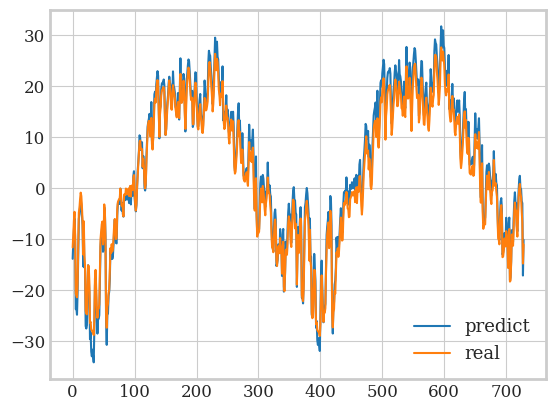

In [264]:
y_pred = reg.predict(x_test)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))
plt.plot(range(len(y_test)), y_test, label="predict")
plt.plot(range(len(y_pred)), y_pred, label="real")
plt.legend()
plt.show()

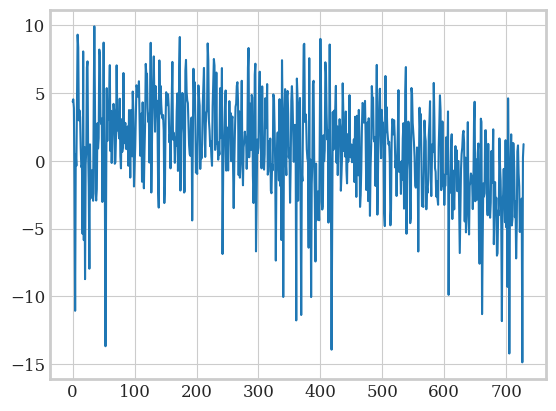

In [265]:
plt.plot(pd.DataFrame(y_valid) - pd.DataFrame(y_pred))

<BarContainer object of 10 artists>

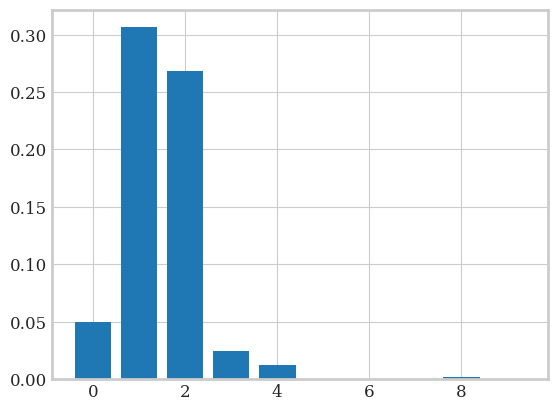

In [266]:
plt.bar(range(10), list(reg.feature_importances_)[:10],)